## Import

In [126]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler

import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


## Generazione dei dati storici degli asset
> Seed ottimale: 1659

In questa cella, eseguiamo i seguenti passaggi:

1. Impostiamo il numero di asset (`assets`) a 8.
2. Definiamo il seme per la generazione casuale (`seed`) al valore 1659.
3. Impostiamo le date di inizio (`start_date`) e fine (`end_date`) del periodo di analisi rispettivamente al 1 gennaio 2016 e al 1 gennaio 2020.
4. Generiamo i ticker per gli asset come una lista di stringhe (`tickers`), con nomi del tipo "TICKER_0", "TICKER_1", ..., "TICKER_7".
5. Inizializziamo un'istanza di `RandomDataProvider` con i seguenti parametri:
   - `tickers`: la lista dei ticker generati.
   - `start`: la data di inizio del periodo di analisi.
   - `end`: la data di fine del periodo di analisi.
   - `seed`: il seme per la generazione casuale.
6. Eseguiamo il metodo `run` del `data_provider` per generare i dati storici degli asset.
7. Memorizziamo i dati storici generati in `stock_data` accedendo all'attributo `_data` del `data_provider`.
8. Creiamo una serie di date (`dates`) utilizzando `pd.date_range` per coprire l'intervallo dal `start_date` al `end_date`, escludendo la data di fine (`inclusive="left"`).

In [127]:
assets = 8
seed = 1659

start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

# Generiamo i dati
tickers = [f"TICKER_{i}" for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=tickers,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()
stock_data = data_provider._data

dates = pd.date_range(start=start_date, end=end_date, inclusive="left")

qaua_color = "blue"
svqe_color = "green"
exact_color = "red"

## Stampa dei dati

In [128]:
# Funzione per stampare la tabella
def print_table(stock_data, tickers, dates):
    print(f"\n{'Dati Generati per il periodo dal':<12} {dates[0].date()} al {dates[-1].date()}:")
    print("-" * 80)
    print(f"{'Data':<12}", end="")
    for ticker in tickers:
        print(f"{ticker:<12}", end="")
    print()
    print("-" * 80)

    for i, date in enumerate(dates):
        print(f"{date.strftime('%Y-%m-%d'):<12}", end="")
        for j in range(len(stock_data)):
            print(f"{stock_data[j][i]:<12.4f}", end="")
        print()
    print("-" * 80)

# print_table(stock_data, tickers, dates)

## Funzione per generare i grafici dei prezzi delle azioni

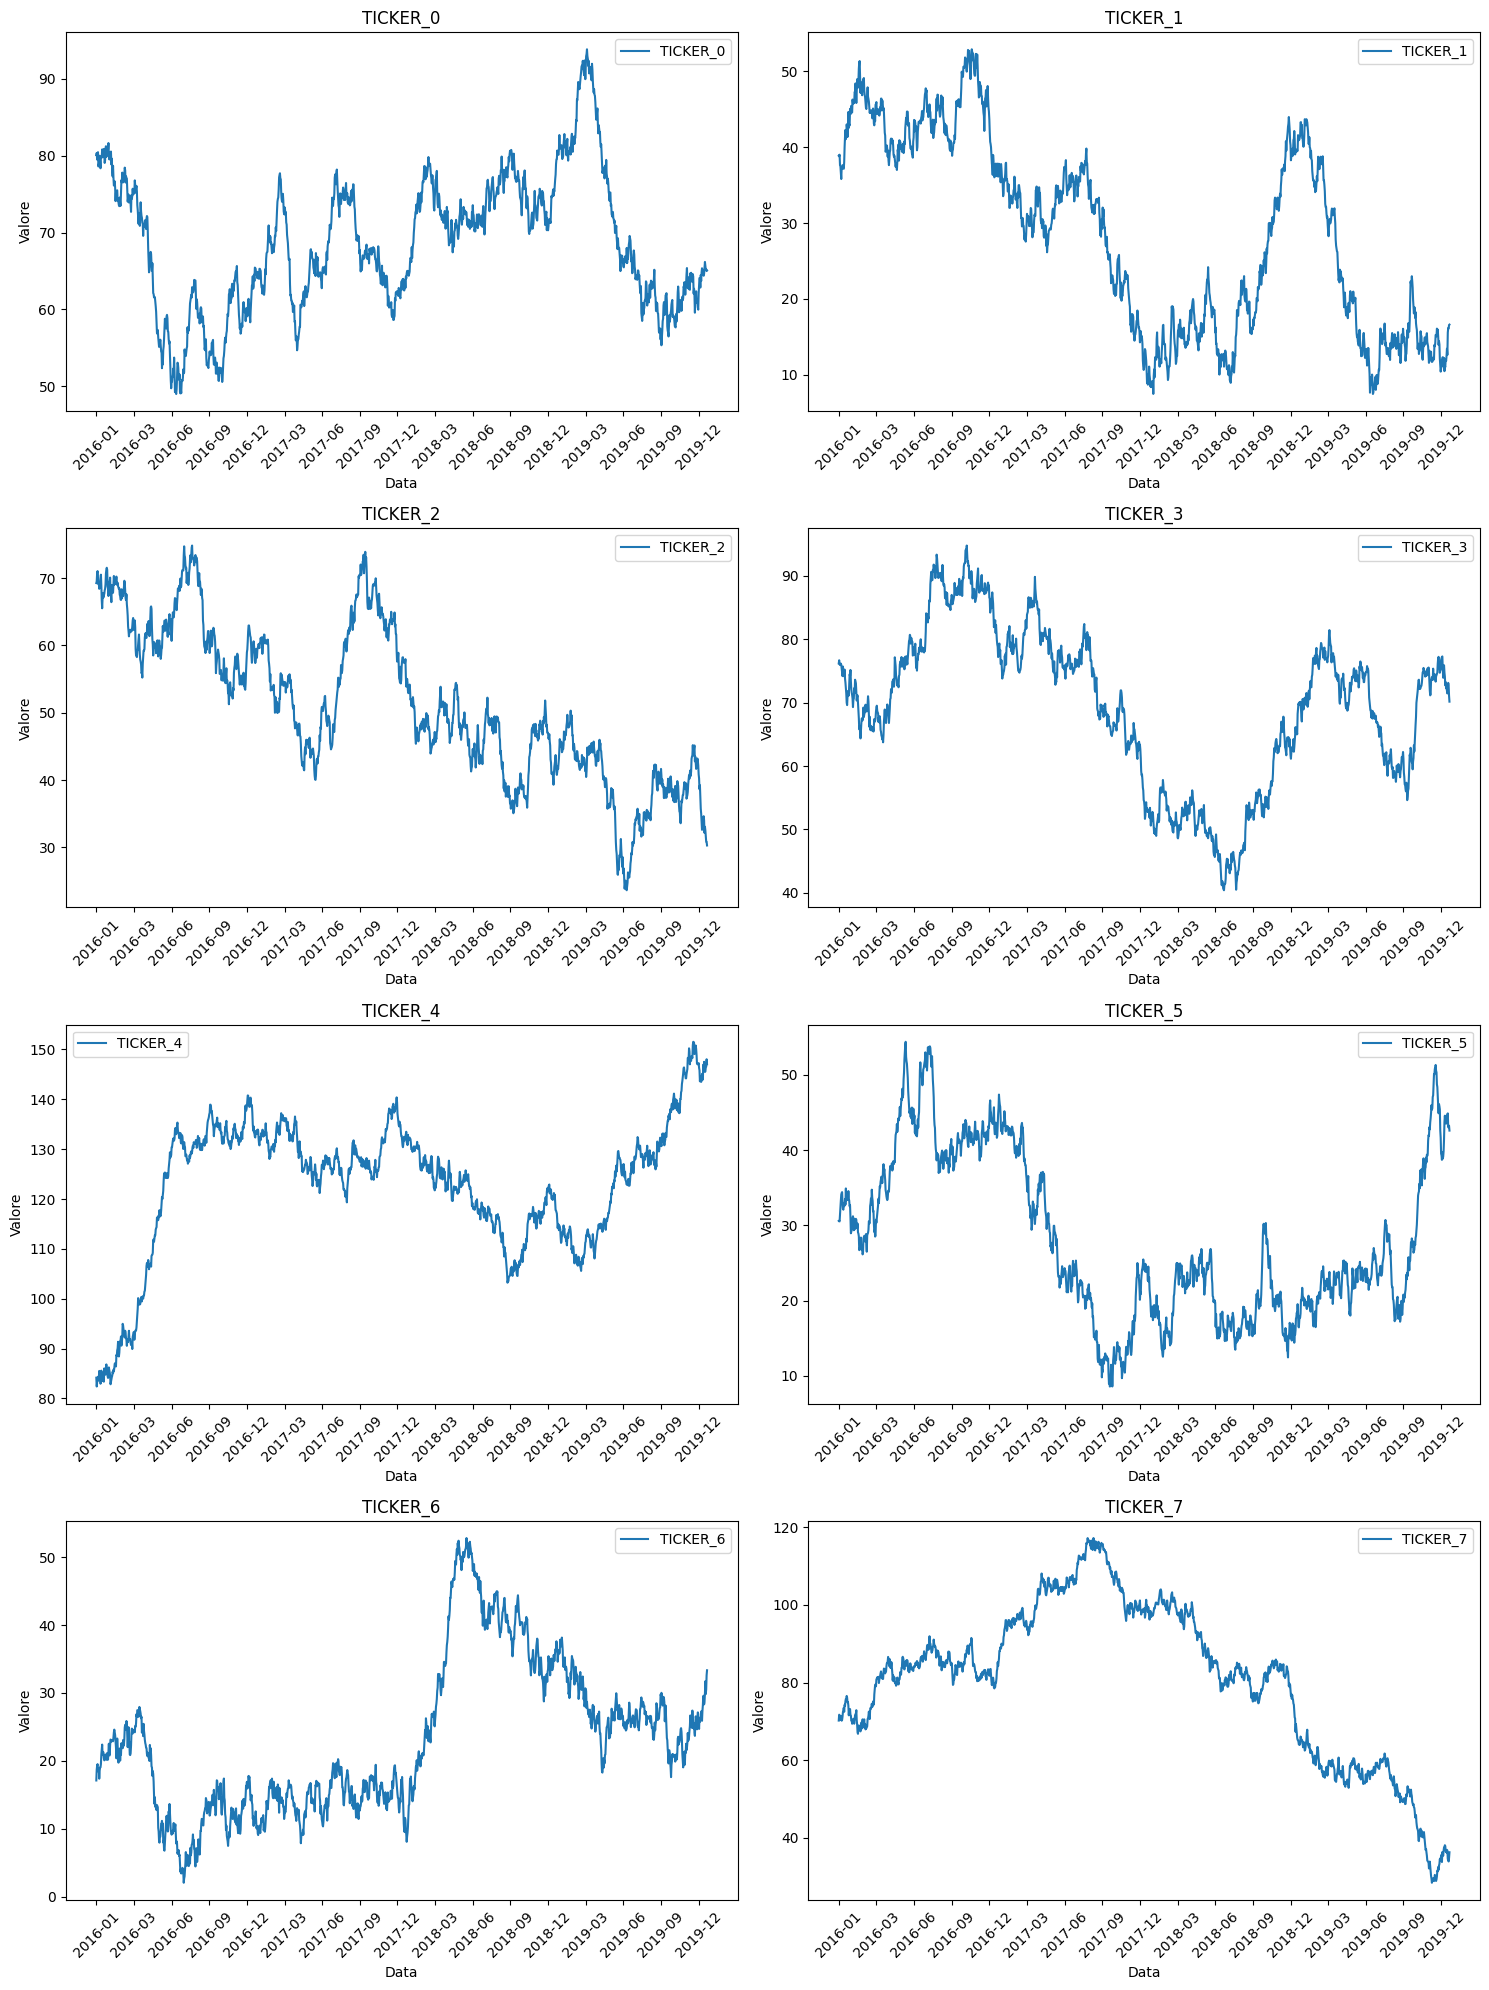

In [129]:
# Funzione per creare i grafici
def create_ticker_plots(stock_data, tickers, dates):
    num_tickers = len(tickers)
    cols = 2  # Numero di colonne nella griglia
    rows = (num_tickers + cols - 1) // cols  # Calcola il numero di righe

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.atleast_1d(axes).flatten()  # Assicura che sia un array piatto

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        ax.plot(dates, stock_data[i], label=ticker)
        ax.set_title(ticker)
        ax.set_xlabel("Data")
        ax.set_ylabel("Valore")

        # Mostra solo i mesi sull'asse x
        ax.set_xticks(dates[::90])  # Ogni 90 giorni (circa un trimestre)
        ax.set_xticklabels([date.strftime('%Y-%m') for date in dates[::90]], rotation=45)
        ax.legend()

    # Rimuovi eventuali subplot vuoti
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

create_ticker_plots(stock_data, tickers, dates)

## Matrice di covarianza degli assets

In questa cella, eseguiamo i seguenti passaggi:
1. Calcoliamo il vettore medio dei rendimenti periodici (`mu`) utilizzando il metodo `get_period_return_mean_vector` del `data_provider`.
2. Calcoliamo la matrice di covarianza dei rendimenti periodici (`sigma`) utilizzando il metodo `get_period_return_covariance_matrix` del `data_provider`.
3. Creiamo un DataFrame Pandas (`sigma_df`) per la matrice di covarianza, utilizzando i ticker degli asset come indici e colonne.
4. Visualizziamo la matrice di covarianza degli asset utilizzando una heatmap di Seaborn:
   - Impostiamo la dimensione della figura a 8x6 pollici.
   - Utilizziamo `sns.heatmap` per creare la heatmap, con annotazioni dei valori, formato dei numeri a 4 cifre decimali, mappa di colori "coolwarm", barra dei colori, larghezza delle linee di 0.5 e celle quadrate.
   - Impostiamo il titolo della heatmap a "Matrice di covarianza degli assets".
5. Mostriamo la heatmap con `plt.show()`.

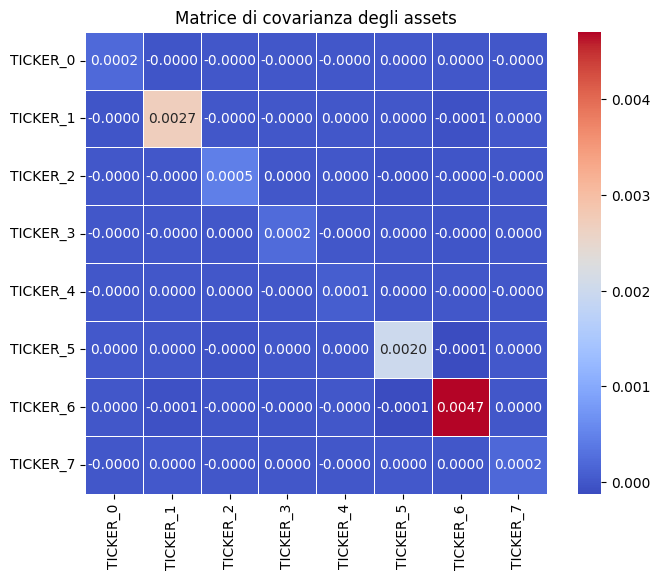

In [130]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

sigma_df = pd.DataFrame(sigma, index=tickers, columns=tickers)

plt.figure(figsize=(8, 6))
sns.heatmap(
    sigma_df, 
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    square=True
)
plt.title("Matrice di covarianza degli assets")
plt.show()

## Configurazione del problema

In questa cella, eseguiamo i seguenti passaggi:

1. Impostiamo il fattore di rischio (`risk_factor`) al valore di 0.2.
2. Definiamo il budget come la metà del numero totale di asset (`assets // 2`), il che significa che selezioneremo il 50% degli asset.
3. Inizializziamo un'istanza di `PortfolioOptimization` con i seguenti parametri:
   - `expected_returns`: il vettore dei rendimenti attesi (`mu`).
   - `covariances`: la matrice di covarianza dei rendimenti (`sigma`).
   - `risk_factor`: il fattore di rischio impostato a 0.2.
   - `budget`: il budget impostato a metà del numero totale di asset.
4. Convertiamo il problema di ottimizzazione del portafoglio in un programma quadratico (`qp`) utilizzando il metodo `to_quadratic_program` dell'istanza `PortfolioOptimization`.

In [131]:
risk_factor = 0.2
budget = assets // 2 # 50% of the assets

# TODO dobbiamo impostare la penalità se si supera il budget
po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()

## Configurazione degli algoritmi

In questa cella, configuriamo e inizializziamo gli algoritmi di ottimizzazione del portafoglio che verranno utilizzati per risolvere il problema:

1. **Variabili comuni**:
   - Impostiamo il seme per la generazione casuale utilizzando `algorithm_globals.random_seed`.
   - Configuriamo l'ottimizzatore `COBYLA` con un numero massimo di iterazioni (`maxiter`) pari a 1000.

2. **Classical**:
   - Inizializziamo l'ottimizzatore classico `Exact Eigensolver` utilizzando `NumPyMinimumEigensolver` e `MinimumEigenOptimizer`.

3. **VQE**:
   - Configuriamo l'ansatz `TwoLocal` con rotazioni `ry` e gate `cz`, con entanglement completo e barriere inserite.
   - Inizializziamo `SamplingVQE` con il campionatore `Sampler`, l'ansatz configurato e l'ottimizzatore `COBYLA`.
   - Inizializziamo l'ottimizzatore `MinimumEigenOptimizer` con `SamplingVQE`.

4. **QAOA**:
   - Impostiamo nuovamente il seme per la generazione casuale utilizzando `algorithm_globals.random_seed`.
   - Inizializziamo `QAOA` con il campionatore `Sampler`, l'ottimizzatore `COBYLA` e un numero di ripetizioni (`reps`) pari a 1.
   - Inizializziamo l'ottimizzatore `MinimumEigenOptimizer` con `QAOA`.

In [132]:
# Variabili comuni per VQE e QAOA
algorithm_globals.random_seed = seed
cobyla = COBYLA()
iter = 1000
cobyla.set_options(maxiter=iter)

# Classico
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

# VQE
ry = TwoLocal(assets, "ry", "cz", reps=1, entanglement="full", insert_barriers=True)
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)

# QAOA
algorithm_globals.random_seed = seed
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)

## Esecuzione degli algoritmi di ottimizzazione del portafoglio e visualizzazione dei risultati
La selezione di ogni asset è rappresentata da un valore binario (1 = selezionato, 0 = non selezionato).

In questa cella, eseguiamo i seguenti passaggi:

1. Definiamo i parametri iniziali come `n_repeats` e `risk_factor`.
2. Inizializziamo le matrici per memorizzare le selezioni degli asset per ciascun algoritmo (`QAOA`, `SVQE`, `Exact Eigensolver`).
3. Generiamo tutte le possibili combinazioni di selezione degli asset e inizializziamo un dizionario per contare le occorrenze di ciascuna combinazione per ogni algoritmo.
4. Creiamo un'istanza di `PortfolioOptimization` e convertiamo il problema in un programma quadratico.
5. Eseguiamo ciascun algoritmo `n_repeats` volte, memorizzando le selezioni degli asset e aggiornando i contatori delle combinazioni.
6. Calcoliamo il numero totale di selezioni per ciascun asset per ogni algoritmo.
7. Filtriamo le combinazioni con valore 0 per visualizzare solo quelle con almeno una selezione.
8. Creiamo una griglia di grafici (1 riga e 3 colonne) per visualizzare la distribuzione delle selezioni degli asset per ciascun algoritmo.
9. Creiamo un grafico combinato per visualizzare la distribuzione delle selezioni degli asset per tutti gli algoritmi.
10. Creiamo un grafico a barre per visualizzare la frequenza delle combinazioni di selezione degli asset per ciascun algoritmo, utilizzando una scala logaritmica in base 2 per l'asse delle y.

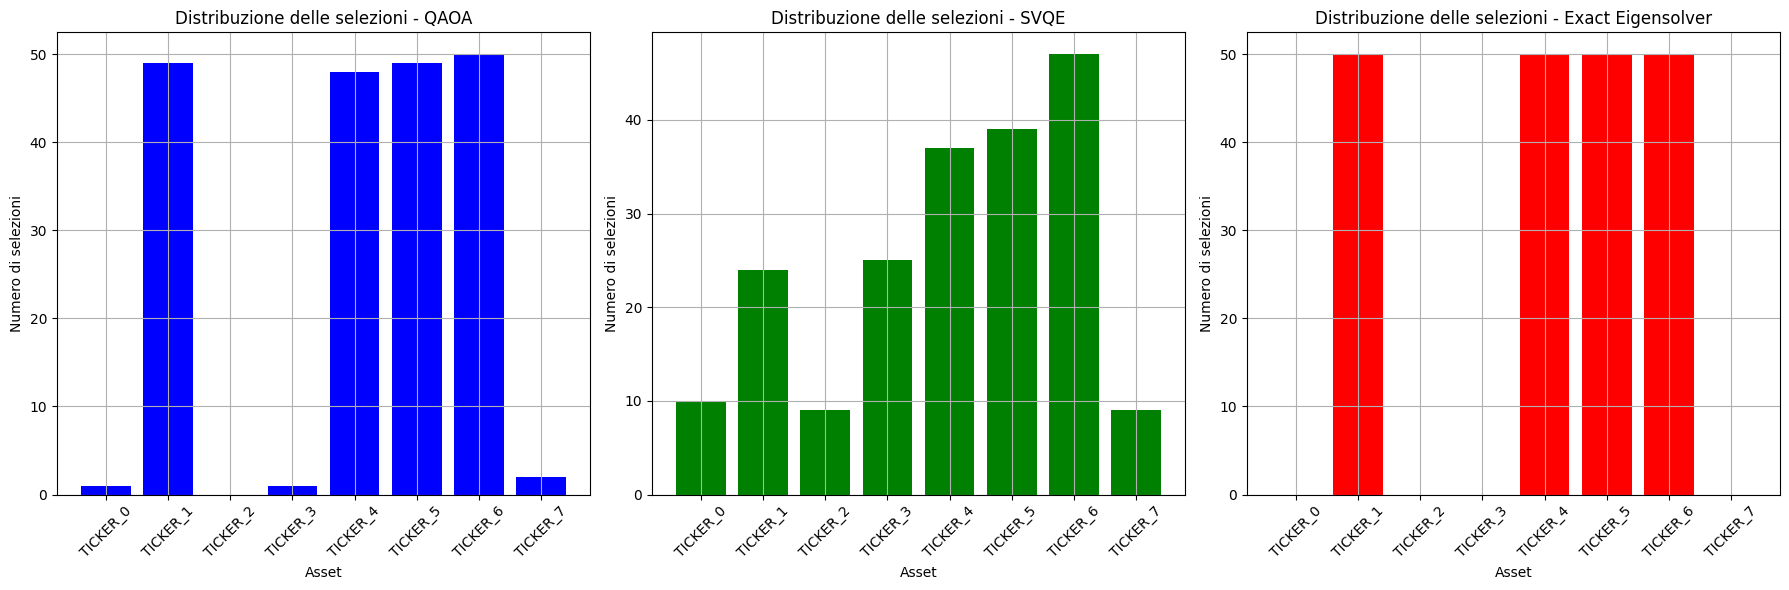

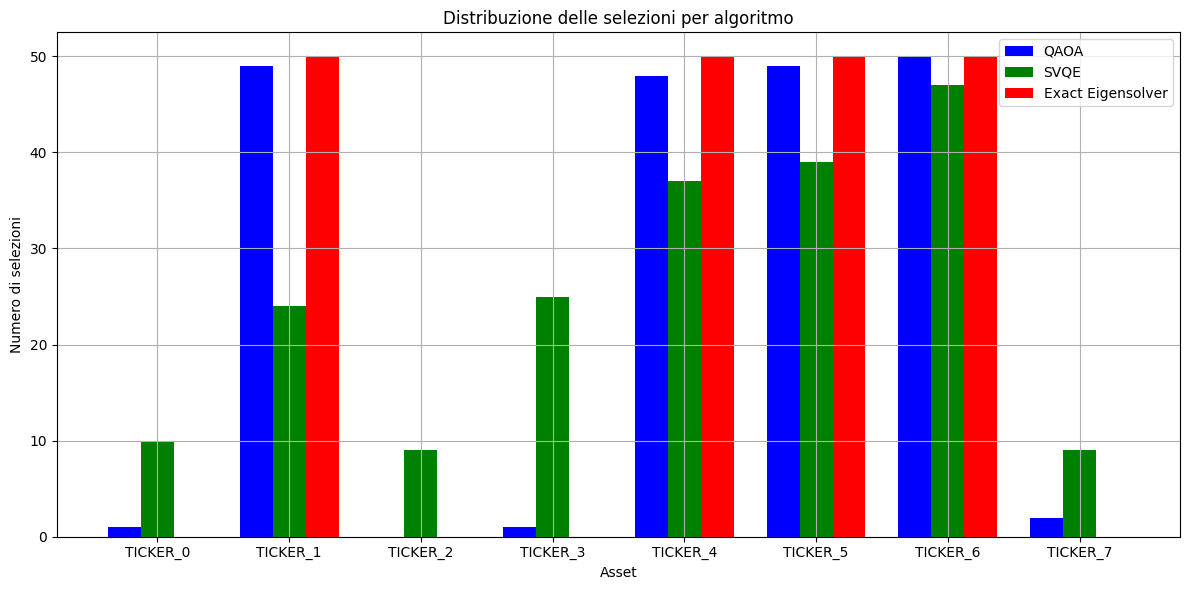

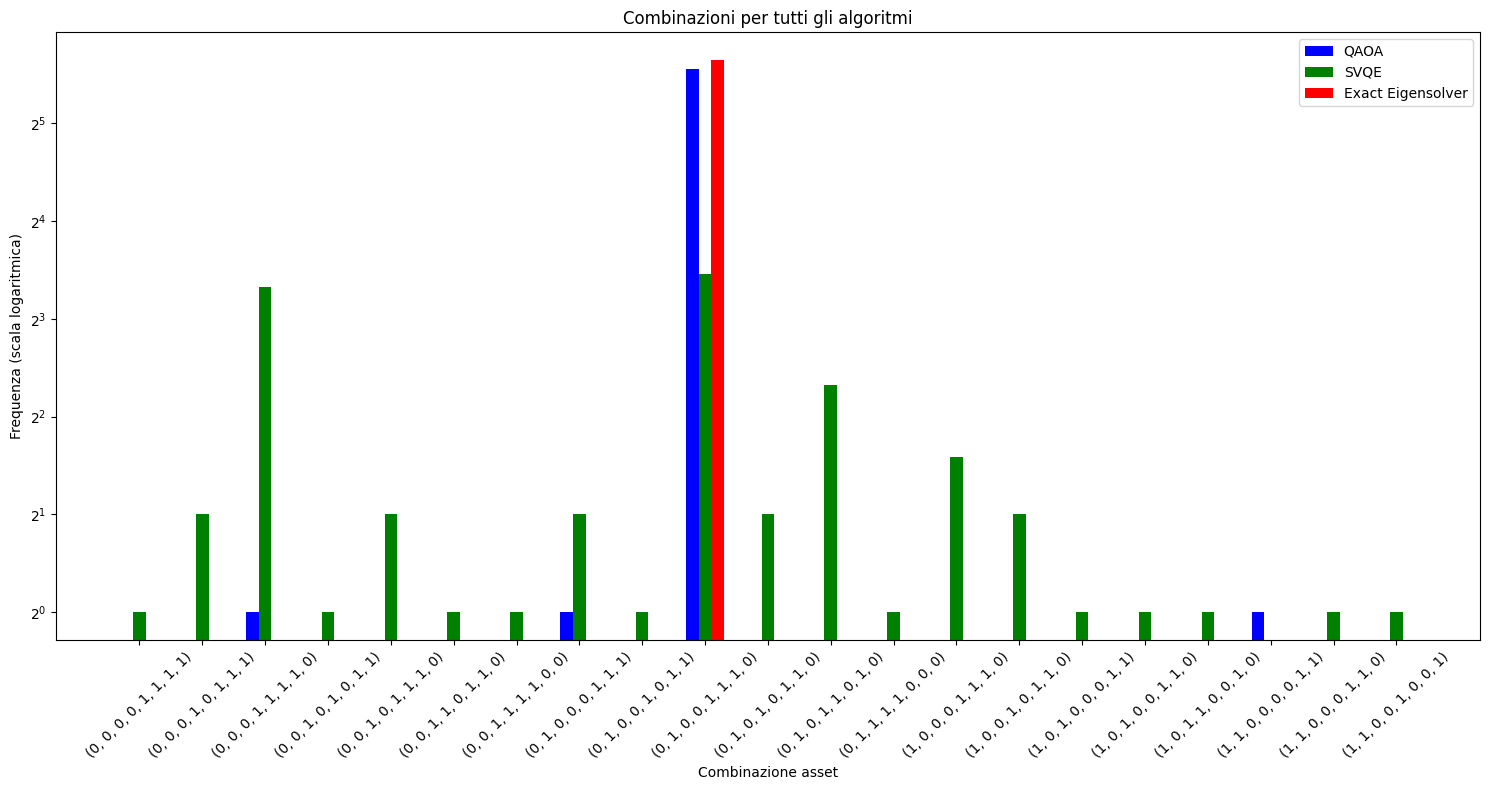

In [133]:
n_repeats = 50

selections_qaoa = np.zeros((n_repeats, len(tickers)))
selections_svqe = np.zeros((n_repeats, len(tickers)))
selections_exact_eigensolver = np.zeros((n_repeats, len(tickers)))

all_combinations = list(itertools.product([0, 1], repeat=assets))
combinations_count = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
    'exact': {comb: 0 for comb in all_combinations}
}

po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
qp = po.to_quadratic_program()

for i in range(n_repeats):
    result_qaoa = qaoa.solve(qp)
    selections_qaoa[i] = result_qaoa.x
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe.solve(qp)
    selections_svqe[i] = result_svqe.x
    selection_svqe = tuple(result_svqe.x)

    result_exact = exact_eigensolver.solve(qp)
    selections_exact_eigensolver[i] = result_exact.x
    selection_exact = tuple(result_exact.x)

    combinations_count['qaoa'][selection_qaoa] += 1
    combinations_count['svqe'][selection_svqe] += 1
    combinations_count['exact'][selection_exact] += 1

selection_counts_qaoa = np.sum(selections_qaoa, axis=0)
selection_counts_svqe = np.sum(selections_svqe, axis=0)
selection_counts_exact_eigensolver = np.sum(selections_exact_eigensolver, axis=0)

combinations = list(combinations_count['qaoa'].keys())
frequencies_qaoa = list(combinations_count['qaoa'].values())
frequencies_svqe = list(combinations_count['svqe'].values())
frequencies_exact = list(combinations_count['exact'].values())

# Filtra le combinazioni con valore 0
filtered_combinations = []
filtered_frequencies_qaoa = []
filtered_frequencies_svqe = []
filtered_frequencies_exact = []

for comb, fq, fs, fe in zip(combinations, frequencies_qaoa, frequencies_svqe, frequencies_exact):
    if fq > 0 or fs > 0 or fe > 0:
        filtered_combinations.append(comb)
        filtered_frequencies_qaoa.append(fq)
        filtered_frequencies_svqe.append(fs)
        filtered_frequencies_exact.append(fe)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico per QAOA
axs[0].bar(tickers, selection_counts_qaoa, color=qaua_color)
axs[0].set_title("Distribuzione delle selezioni - QAOA")
axs[0].set_xlabel("Asset")
axs[0].set_ylabel("Numero di selezioni")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Grafico per SVQE
axs[1].bar(tickers, selection_counts_svqe, color=svqe_color)
axs[1].set_title("Distribuzione delle selezioni - SVQE")
axs[1].set_xlabel("Asset")
axs[1].set_ylabel("Numero di selezioni")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

# Grafico per Exact Eigensolver
axs[2].bar(tickers, selection_counts_exact_eigensolver, color=exact_color)
axs[2].set_title("Distribuzione delle selezioni - Exact Eigensolver")
axs[2].set_xlabel("Asset")
axs[2].set_ylabel("Numero di selezioni")
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.show()

width = 0.25
x = np.arange(len(tickers))

plt.figure(figsize=(12, 6))
plt.bar(x - width, selection_counts_qaoa, width, color=qaua_color, label='QAOA')
plt.bar(x, selection_counts_svqe, width, color=svqe_color, label='SVQE')
plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

plt.title('Distribuzione delle selezioni per algoritmo')
plt.xlabel('Asset')
plt.ylabel('Numero di selezioni')
plt.xticks(x, tickers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Grafico combinazioni
n_combinations = len(filtered_combinations)
indice = np.arange(n_combinations)
larghezza = 0.2  # Larghezza delle barre

plt.figure(figsize=(15, 8))

# Barre per QAOA
plt.bar(indice - larghezza, filtered_frequencies_qaoa, larghezza, color=qaua_color, label='QAOA')
# Barre per SVQE
plt.bar(indice, filtered_frequencies_svqe, larghezza, color=svqe_color, label='SVQE')
# Barre per Exact Eigensolver
plt.bar(indice + larghezza, filtered_frequencies_exact, larghezza, color=exact_color, label='Exact Eigensolver')

plt.yscale('log', base=2)
plt.title("Combinazioni per tutti gli algoritmi")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(indice, [str(comb) for comb in filtered_combinations], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Analisi del rischio vs ritorno atteso per diversi algoritmi

In questa cella, eseguiamo i seguenti passaggi:

1. Definiamo una serie di valori di rischio (`risks`) utilizzando `np.linspace` per generare 20 valori equidistanti tra 0 e 1.
2. Calcoliamo i valori ottimali per ciascun valore di rischio utilizzando i tre algoritmi di ottimizzazione del portafoglio (`QAOA`, `SVQE`, `Exact Eigensolver`):
   - **QAOA**:
     - Inizializziamo una lista vuota (`values_per_risk_qaoa`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `qaoa` e memorizziamo il valore ottimale (`result.fval`) nella lista.
   - **SVQE**:
     - Inizializziamo una lista vuota (`values_per_risk_svqe`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `svqe` e memorizziamo il valore ottimale (`result.fval`) nella lista.
   - **Exact Eigensolver**:
     - Inizializziamo una lista vuota (`values_exact_eigensolver`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `exact_eigensolver` e memorizziamo il valore ottimale (`result.fval`) nella lista.
3. Creiamo un grafico per visualizzare la relazione tra il fattore di rischio e il valore ottimale per ciascun algoritmo:
   - Utilizziamo `plt.plot` per tracciare i valori ottimali in funzione del fattore di rischio per `QAOA`, `SVQE` e `Exact Eigensolver`, con diversi marker e colori per ciascun algoritmo.
   - Impostiamo il titolo del grafico a "Rischio vs ritorno atteso per diversi algoritmi".
   - Etichettiamo gli assi x e y rispettivamente come "Fattore di rischio" e "Valore ottimale".
   - Aggiungiamo una griglia e una legenda per migliorare la leggibilità del grafico.
   - Utilizziamo `plt.tight_layout` per ottimizzare il layout del grafico e `plt.show` per visualizzarlo.

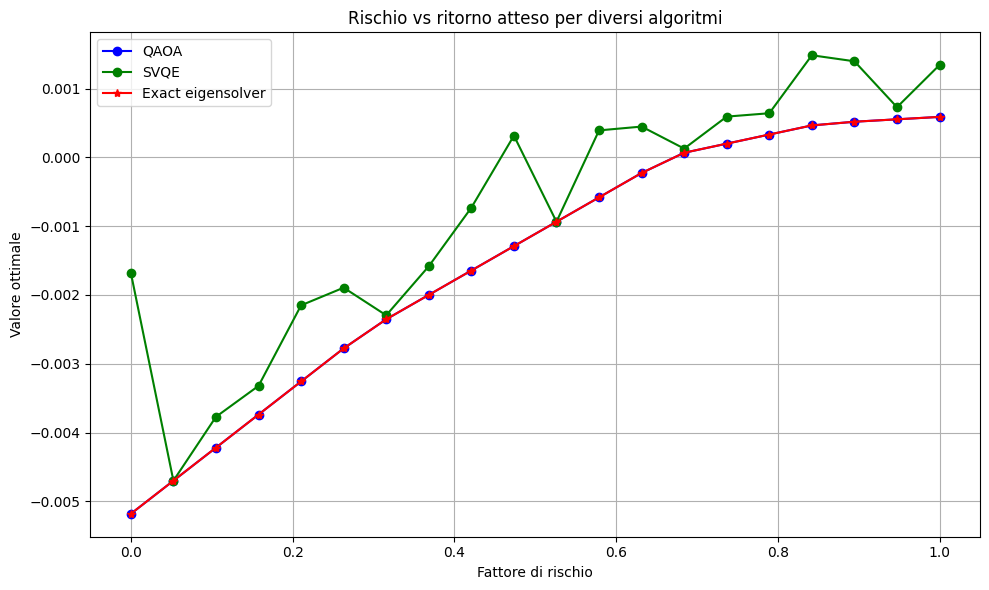

In [134]:
risks = np.linspace(0, 1, 20)

# Risultati per QAOA
values_per_risk_qaoa = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = qaoa.solve(qp)
    values_per_risk_qaoa.append(result.fval)

# Risultati per SVQE
values_per_risk_svqe = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = svqe.solve(qp)
    values_per_risk_svqe.append(result.fval)

# Risultati per Exact Eigensolver
values_exact_eigensolver = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = exact_eigensolver.solve(qp)
    values_exact_eigensolver.append(result.fval)

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plot per QAOA
plt.plot(risks, values_per_risk_qaoa, marker='o', linestyle='-', color=qaua_color, label='QAOA')

# Plot per SVQE
plt.plot(risks, values_per_risk_svqe, marker='o', linestyle='-', color=svqe_color, label='SVQE')

# Plot per Exact Eigensolver
plt.plot(risks, values_exact_eigensolver, marker='*', linestyle='-', color=exact_color, label='Exact eigensolver')

plt.title("Rischio vs ritorno atteso per diversi algoritmi")
plt.xlabel("Fattore di rischio")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()